<a href="https://colab.research.google.com/github/jihoonkim2100/ANPP/blob/master/ANPP_Coherent_73.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
################################################################################ 0. Import the library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from google.colab import drive                                                  
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import Input
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import ttest_ind
from sklearn import svm, linear_model, metrics
from sklearn import preprocessing
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

sns.set(style="darkgrid", color_codes=True)

np.random.seed(20201005)                                                        # To ensure the reproducibility of the programm

In [2]:
################################################################################ PART I: Exploratory Data Analysis and Data Cleaning
                                                                                # 1. Loading the dataset: SENT_GROUP_INFO and SENT_RATING_DATA
drive.mount('/gdrive', force_remount=True)                                      # Mount the files on the google drive to be used with google colab

sg_index = "B:E,AE:AI,CW:DJ,DM,FN"                                              # Select the necessary dataset based on the column indices

s_grp_dir = '/gdrive/My Drive/SCAN_seminar_data/SENT_GROUP_INFO.xlsx'           # Load the dataset SENT_GROUP_INFO 
s_group = pd.read_excel(s_grp_dir, usecols = sg_index)                          # Only loading columns B to E (Case, Text, Condition, Language)
                                                                                #                      AE to AI (BFI scores)
                                                                                #                      CW to DJ (Reading experience ratings)
                                                                                #                      DM, FN (Attention check, Minus points for fast completion = DEG Time)
s_rat_dir = '/gdrive/My Drive/SCAN_seminar_data/SENT_RATING_DATA.xlsx'          # Load the dataset: SENT_RATING_DATA (all columns)
s_rating = pd.read_excel(s_rat_dir)

Mounted at /gdrive


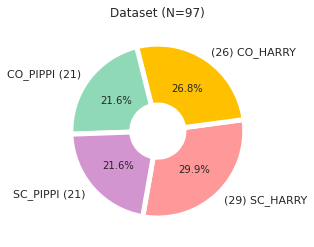

In [3]:
################################################################################ 2. Exploratory Data Analysis: Coherent ENG+GER, HARRY AND PIPPI

                                                                                # SENT_GROUP_INFO.xlsx
sg_harry = s_group['TEXT'] == 'HARRY'                                           # return true only for HARRY
sg_pippi = s_group['TEXT'] == 'PIPPI'                                           # return true only for PIPPI
sg_coherent = s_group['CONDITION'] == 'COHERENT'                                # return true only for COHERENT
sg_scrambled = s_group['CONDITION'] == 'SCRAMBLED'                              # return true only for SCRAMBLED
sg_eng = s_group['QESTN_LANGUAGE'] == 'ENG'                                     # return true only for ENG
sg_ger = s_group['QESTN_LANGUAGE'] == 'GER'                                     # return true only for GER

                                                                                # SENT_RATING_DATA.xlsx
sr_harry = s_rating['TEXT'] == 'HARRY'                                          # retrun true only for HARRY
sr_pippi = s_rating['TEXT'] == 'PIPPI'                                          # retrun true only for PIPPI
sr_coherent = s_rating['CONDITION'] == 'COHERENT'                               # retrun true only for COHERENT
sr_scrambled = s_rating['CONDITION'] == 'SCRAMBLED'                             # retrun true only for SCRAMBLED
sr_eng = s_rating['LANGUAGE'] == 'ENG'                                          # retrun true only for ENG
sr_ger = s_rating['LANGUAGE'] == 'GER'                                          # retrun true only for GER

                                                                                # Data filtering in the certain conditions
sg_co_harry = s_group[sg_harry & sg_coherent]                                   # Text: HARRY; Condition: COHERENT
sg_sc_harry = s_group[sg_harry & sg_scrambled]                                  # Text: HARRY; Condition: SCRAMBLED
sg_co_pippi = s_group[sg_pippi & sg_coherent]                                   # Text: PIPPI; Condition: COHERENT
sg_sc_pippi = s_group[sg_pippi & sg_scrambled]                                  # Text: PIPPI; Condition: SCRAMBLED

categories = ['(29) SC_HARRY','(26) CO_HARRY','CO_PIPPI (21)','SC_PIPPI (21)']  # Plot a pie chart of the distribution of the whole dataset (N=97)
sizes = [len(sg_sc_harry),len(sg_co_harry),len(sg_sc_pippi),len(sg_sc_pippi)]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=260,
       colors=colors,wedgeprops=wedgeprops)
plt.title('Dataset (N=97)')
plt.show()

bad data case list: [9, 19, 48, 84, 96, 87]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


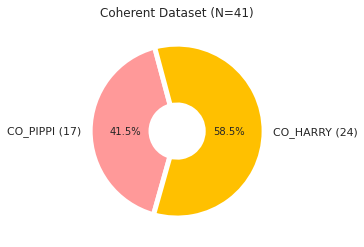

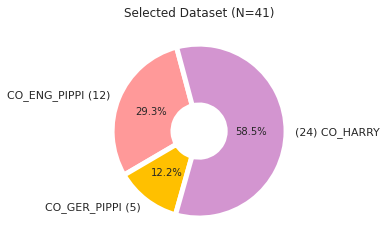

In [4]:
################################################################################ 3. Data Cleaning (Exclude the "bad data") and visualisation
sg_co = s_group[sg_coherent]
sr_co = s_rating[sr_coherent]
                                                                                ### Selecting the cases with "bad data"

                                                                                #Criteria that renders a case as "bad data" are:
b_DEG = sg_co.loc[sg_co['DEG_TIME']>100]['CASE']                                #       1. DEG_TIME > 100 (completion of the survey was too fast)

b_ATT = sg_co.loc[sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS']>0]['CASE']      #       2. ATTENTION_CHECKS_COUNT_WRONG_ANSWERS > 0 (clicking random answeres)

b_PAG = sr_co.loc[sr_co['PAGE_TIME']>999]['CASE']                               #       3. PAGE_TIME > 999 (pausing while completing the survey, can interfere with immersion)

b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)                             # Concatenate the "bad data" described above into a single list

b_list = b_list.drop_duplicates()                                               # Delete the duplicates
b_case = list(b_list.values)                                                    # Make of list of the cases considered to be "bad data" (list of case number)
print('bad data case list:',b_case)

                                                                                
                                                                                ### Excluding the "bad data" cases from the dataset

a_group = sg_co.copy()                                                          # Copy the SENT_GROUP_INFO.coherent
a_rating = sr_co.copy()                                                         # Copy the # SENT_RATING_DATA.coherent

for i in b_case:                                                                # Exclude the bad case from the coherent dataset
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)

sg_co_harry = a_group[sg_harry & sg_coherent]                                   # Text: HARRY; Condition: COHERENT, bad data excluded
sg_sc_harry = a_group[sg_harry & sg_scrambled]                                  # Text: HARRY; Condition: SCRAMBLED, bad data excluded
sg_co_pippi = a_group[sg_pippi & sg_coherent]                                   # Text: PIPPI; Condition: COHERENT, bad data excluded
sg_sc_pippi = a_group[sg_pippi & sg_scrambled]                                  # Text: PIPPI; Condition: SCRAMBLED, bad data excluded
sg_co_en_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                       # Text: PIPPI; Condition: COHERENT; Language: ENG
sg_co_ge_pippi = a_group[sg_pippi & sg_coherent & sg_ger]                       # Text: PIPPI; Condition: COHERENT; Language: GER

categories = ['CO_PIPPI (17)','CO_HARRY (24)']                                  # Plot the pie chart of the distribution of the COHERENT dataset (N=41)
                                                                                # Two pie chart slices:                                                                               
sizes = [len(sg_co_pippi),len(sg_co_harry)]                                     #    Text: PIPPI; Condition: COHERENT
colors = ['#ff9999', '#ffc000']                                                 #    Text: HARRY; Condition: COHERENT
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=105,
       colors=colors,wedgeprops=wedgeprops)
plt.title('Coherent Dataset (N=41)')                                            
plt.show()                                                                     


categories = ['CO_ENG_PIPPI (12)','CO_GER_PIPPI (5)','(24) CO_HARRY']           # Plot the pie chart of the distribution of the COHERENT dataset (N=41)
sizes = [len(sg_co_en_pippi),len(sg_co_ge_pippi),len(sg_co_harry)]              # Three pie chart slices: 
colors = ['#ff9999', '#ffc000','#d395d0']                                       #    Text: HARRY; Condition: COHERENT 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}                     #    Text: PIPPI; Condition: COHERENT; Language: ENG
                                                                                #    Text: PIPPI; Condition: COHERENT; Language: GER
fig, ax = plt.subplots()
ax.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=105,                # 
       colors=colors,wedgeprops=wedgeprops)                                     # 
plt.title('Selected Dataset (N=41)')                                            #
plt.show()                                                                      #

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


HARRY
CASE              0
AROUSAL_RATING    0
VALENCE_RATING    0
dtype: int64 NaN
PIPPI
CASE              0
AROUSAL_RATING    0
VALENCE_RATING    0
dtype: int64 NaN
Coherent demographic informations: 
            CASE  ...   DEG_TIME
count  24.000000  ...  24.000000
mean   39.916667  ...  12.625000
std    24.313025  ...  11.948485
min     3.000000  ...   0.000000
25%     9.500000  ...   6.000000
50%    52.500000  ...   9.000000
75%    58.250000  ...  14.500000
max    64.000000  ...  45.000000

[8 rows x 22 columns]
              CASE    PAGE_TIME  ...  AROUSAL_RATING  VALENCE_RATING
count  3000.000000  3000.000000  ...     3000.000000     3000.000000
mean     39.916667    18.652667  ...        3.129333        4.545333
std      23.805082    26.659175  ...        0.923521        1.340601
min       3.000000     2.000000  ...        1.000000        1.000000
25%       9.500000     8.000000  ...        3.000000        4.000000
50%      52.500000    11.000000  ...        3.000000        4.00

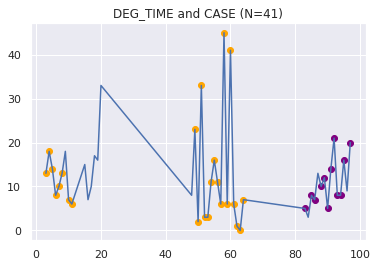

b_DEG []


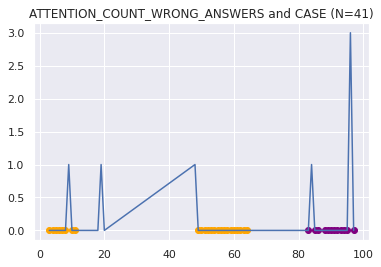

b_ATT [9, 19, 48, 84, 96]


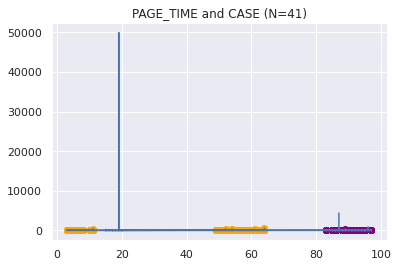

b_PAG [19, 19, 19, 87]


In [6]:
################################################################################ Set the data with Condition: COHERENT only
                                                                                # Loading data from SENT_RATING file for:
ar_co_harry = a_rating[sr_harry & sr_coherent]                                  #   Text: HARRY; Condition: COHERENT
ar_co_pippi = a_rating[sr_pippi & sr_coherent & sr_eng]                         #   Text: PIPPI; Condition: COHERENT; Language: ENG

                                                                                #  Loading data from SENT_GROUP_INFO file for:
ag_co_harry = a_group[sg_harry & sg_coherent]                                   #   Text: HARRY; Condition: COHERENT
ag_co_pippi = a_group[sg_pippi & sg_coherent & sg_eng]                          #   Text: PIPPI; Condition: COHERENT; Language: ENG

################################################################################ drop out the NaN column from the data from SENT_GROUP_INFO file:
gh = ag_co_harry                                                                # Text: HARRY; Condition: COHERENT
gp = ag_co_pippi                                                                # Text: PIPPI; Condition: COHERENT; Language: ENG
                                                                                # Charachter names: legend
rh = ar_co_harry.loc[:,['CASE','AROUSAL_RATING','VALENCE_RATING']]              # Text: HARRY; Condition: COHERENT in SENT_RATING_DATA
                                                                                # rh = ratings harry from file SENT_RATING
                                                                                #      contains: CASE, AROUSAL ratings, VALENCE ratings for Text: HARRY; Condition: COHERENT
rp = ar_co_pippi.loc[:,['CASE','AROUSAL_RATING','VALENCE_RATING']]              # Text: PIPPI; Condition: COHERENT; Language: ENG in SENT_RAITING_DATA
rp = rp.dropna(axis=0)                                                          # drop out NaN row
                                                                                # rp = ratings pippi from file SENT_RATING
                                                                                #      contains: CASE, AROUSAL ratings, valence ratings for Text: PIPPI; Condition: COHERENT; Language: ENG
print('HARRY')
print(rh.isnull().sum(), 'NaN')                                                 # check the NaN
print('PIPPI')
print(rp.isnull().sum(), 'NaN')                                                 # check the NaN

print("Coherent demographic informations: ")                                    # Demographic info on the countable columns
print(ag_co_harry.describe())
print(ar_co_harry.describe())

################################################################################ Additional Plots
plt.title('DEG_TIME and CASE (N=41)')                                           # Plot the DEG_TIME
plt.scatter(ag_co_harry['CASE'], ag_co_harry['DEG_TIME'], c='orange')
plt.scatter(ag_co_pippi['CASE'], ag_co_pippi['DEG_TIME'], c='purple')
plt.plot(sg_co['CASE'], sg_co['DEG_TIME'])
plt.show()
print('b_DEG', list(b_DEG))                                                     # Print the case of DEG_TIME

plt.title('ATTENTION_COUNT_WRONG_ANSWERS and CASE (N=41)')                      # Plot the ATTENTION_COUNT_WRONG_ANSWERS
plt.scatter(ag_co_harry['CASE'],ag_co_harry['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'],c='orange')
plt.scatter(ag_co_pippi['CASE'],ag_co_pippi['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'],c='purple')
plt.plot(sg_co['CASE'],sg_co['ATTENTION_CHECKS_COUNT_WRONG_ANSWERS'])
plt.show()
print('b_ATT', list(b_ATT))                                                     # Print the case of ATTENTION_CHECKS_COUNT_WRONG_ANSWERS

plt.title('PAGE_TIME and CASE (N=41)')                                          # Plot the PAGE_TIME
plt.scatter(ar_co_harry['CASE'], ar_co_harry['PAGE_TIME'], c='orange')
plt.scatter(ar_co_pippi['CASE'], ar_co_pippi['PAGE_TIME'], c='purple')
plt.plot(sr_co['CASE'], sr_co['PAGE_TIME'])
plt.show()
print('b_PAG', list(b_PAG))                                                     # Print the case of PAGE_TIME

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


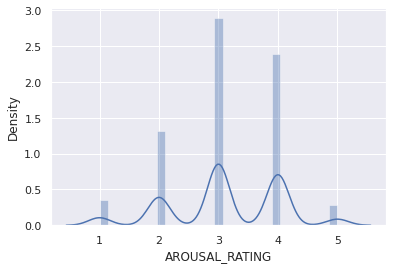

In [7]:
################################################################################ AROUSAL_RATING and VALENCE_RATING HARRY distribution
s_rating_filtered = rh.filter(["VALENCE_RATING", "AROUSAL_RATING"])
sns.distplot(s_rating_filtered["AROUSAL_RATING"])                               # AROUSAL_RATING in Text: HARRY; Condition: COHERENT

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


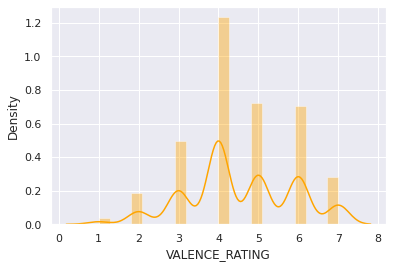

In [8]:
sns.distplot(s_rating_filtered['VALENCE_RATING'], color='orange')               # VALENCE_RATING in Text: HARRY; Condition: COHERENT

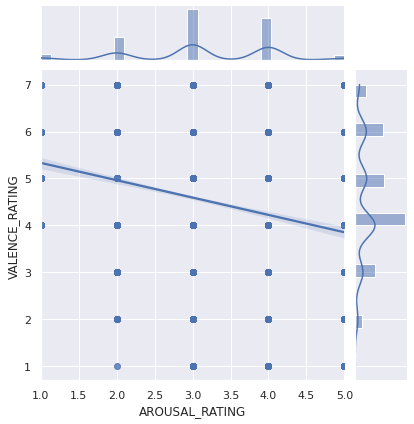

In [9]:
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',                            # Joint plot of the both VALENCE_RATING and AROUSAL_RATING in HARRY
              data = s_rating_filtered,kind='reg')                              # Text: HARRY; Condition: COHERENT

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


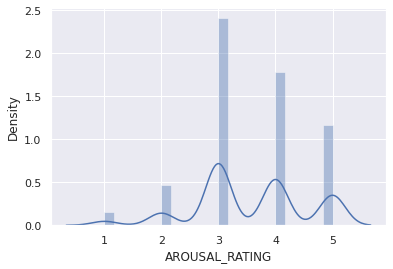

In [10]:
################################################################################ AROUSAL_RATING and VALENCE_RATING PIPPI distribution
s_rating_filtered = rp.filter(["VALENCE_RATING", "AROUSAL_RATING"])
sns.distplot(s_rating_filtered["AROUSAL_RATING"])                               # AROUSAL_RATING in Text: PIPPI; Condition: COHERENT; Language: ENG

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


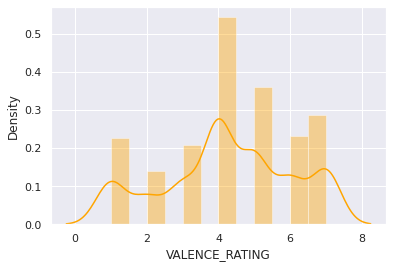

In [11]:
sns.distplot(s_rating_filtered['VALENCE_RATING'], color='orange')               # VALENCEL_RATING in Text: PIPPI; Condition: COHERENT; Language: ENG

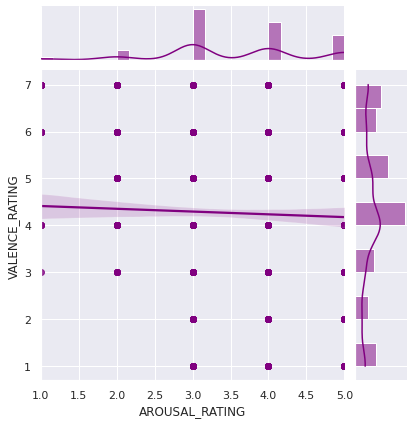

In [12]:
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',                            # Joint plot of the both VALENCE_RATING and AROUSAL_RATING in 
              data = s_rating_filtered,kind='reg',color ='purple')              # Text: PIPPI; Condition: COHERENT; Language: ENG

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13  5.750000
3      4  HARRY  ...       18  4.750000
4      5  HARRY  ...       14  2.250000
5      6  HARRY  ...        8  4.333333
6      7  HARRY  ...       10  5.166667
7      8  HARRY  ...       13  5.750000
9     10  HARRY  ...        7  5.000000
10    11  HARRY  ...        6  4.916667
48    49  HARRY  ...       23  2.916667
49    50  HARRY  ...        2  4.250000

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


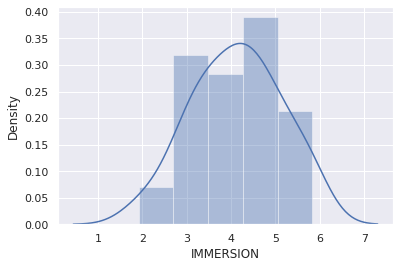

In [15]:
################################################################################ PART II: Design the dependent variable, level of immersion
rg_set = pd.concat([gh,gp], axis = 0)                                           # Merge the HARRY and PIPPI dataset
a_group = rg_set.copy()                                                         # Copy the dataset
h_group = gh.copy()
p_group = gp.copy()

## Characters names: legend:
# gh = data from SENT_GROUP_INFO Text: HARRY; Condition: COHERENT
#
# gp = data from SENT_GROUP_INFO Text: PIPPI; Condition: COHERENT; Language: ENG
#
# a_group: reading experience ratings for Text: HARRY; Condition: COHERENT and Text: PIPPI; Condition: COHERENT; Language: ENG
# h_group: reading experience ratings for Text: HARRY; Condition: COHERENT
# p_group: reading experience ratings for Text: PIPPI; Condition: COHERENT; Language: ENG


a_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'

reader_response = [16,17,22]                                                    # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    a_group['IMMERSION'] += a_group.iloc[:,i] ################################### !!!!! [:,i+1], i=8 is BFI_OPENESS

a_group['IMMERSION']=a_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(a_group.head(10))
sns.distplot(a_group["IMMERSION"])
                                                                                 

    CASE   TEXT  ... DEG_TIME IMMERSION
2      3  HARRY  ...       13  5.000000
3      4  HARRY  ...       18  4.309524
4      5  HARRY  ...       14  2.833333
5      6  HARRY  ...        8  4.357143
6      7  HARRY  ...       10  4.404762
7      8  HARRY  ...       13  5.357143
9     10  HARRY  ...        7  4.214286
10    11  HARRY  ...        6  3.261905
48    49  HARRY  ...       23  2.357143
49    50  HARRY  ...        2  4.190476

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


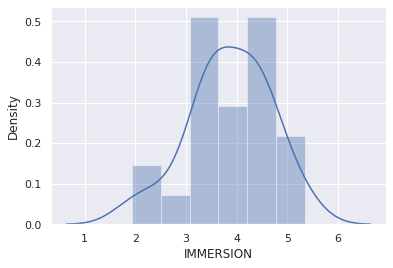

In [16]:
h_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION' for 
                                                                                # Text: HARRY, Condition: COHERENT
reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    h_group['IMMERSION'] += h_group.iloc[:,i]

h_group['IMMERSION']=h_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(h_group.head(10))
sns.distplot(h_group["IMMERSION"])                                              

    CASE   TEXT  ... DEG_TIME IMMERSION
82    83  PIPPI  ...        5  4.880952
84    85  PIPPI  ...        8  3.142857
85    86  PIPPI  ...        7  3.690476
87    88  PIPPI  ...       10  4.357143
88    89  PIPPI  ...       12  3.047619
89    90  PIPPI  ...        5  4.476190
90    91  PIPPI  ...       14  4.285714
91    92  PIPPI  ...       21  3.880952
92    93  PIPPI  ...        8  3.357143
93    94  PIPPI  ...        8  3.547619

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


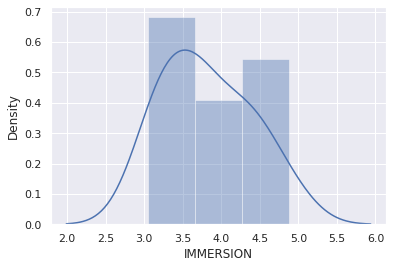

In [17]:
p_group['IMMERSION'] = 0                                                        # Create the new column of 'IMMERSION'
                                                                                # For Text: PIppi, Condition: COHERENT, Language: ENG
reader_response = [8,9,10,11,15,16,21]                                          # Select the reader's responses
                                                                                # If you need it then check the columns order, "print(a_group.columns)"
for i in reader_response:                                                       # Sum the reader's response
    p_group['IMMERSION'] += p_group.iloc[:,i]

p_group['IMMERSION']=p_group['IMMERSION']/len(reader_response)                  # Using the arithmetic mean of the reader's response
print(p_group.head(10))
sns.distplot(p_group["IMMERSION"])   

In [18]:
################################################################################ PART III: Statistical Analysis Immersion with other variable
e_group = a_group.copy()
e_group.head()

#e_group = h_group.copy()
#e_group.head()

#e_group = p_group.copy()
#e_group.head()

,CASE,TEXT,CONDITION,QESTN_LANGUAGE,BFI_EXTRAVERSION,BFI_AGREEABLENESS,BFI_CONSCIENTIOUSNESS,BFI_NEUROTICISM,BFI_OPENNESS,FOCUSING_OF_ATTENTION,TEXT_ABSORPTION,IMAGINABILITY,SPATIAL_INVOLVEMENT,RECEPTION_TERMINATION,SUSPENSE,EMOTIONAL_INVOLVEMENT,GENERAL_READING_ENJOYMENT,IDENTIFICATION,PARASOCIAL_INTERACTION,COGNITIVE_INVOLVEMENT,THEMATIC_INTEREST,ANALYTICAL_RECEPTION,EASE_OF_COGNITIVE_ACCESS,ATTENTION_CHECKS_COUNT_WRONG_ANSWERS,DEG_TIME,IMMERSION
2,3,HARRY,COHERENT,GER,3.5,3.0,4.0,2.5,4.0,5.5,4.5,6.0,4.0,4.5,5.5,6.0,6.0,5.75,6,6.0,6.0,3.000000,5.5,0,13,5.750000
3,4,HARRY,COHERENT,GER,3.5,3.0,3.0,3.0,4.5,3.5,3.5,5.5,3.5,2.5,3.5,5.0,4.5,4.75,4,3.0,5.0,3.666667,5.0,0,18,4.750000
4,5,HARRY,COHERENT,GER,3.5,2.5,3.5,4.5,2.5,3.5,1.5,2.0,1.5,3.0,2.0,3.5,2.5,3.25,1,2.5,1.0,4.333333,1.0,0,14,2.250000
5,6,HARRY,COHERENT,GER,4.5,4.0,5.0,2.5,5.0,5.0,2.5,4.5,3.5,3.0,5.0,5.5,5.0,3.50,3,4.0,5.0,3.000000,4.5,0,8,4.333333
6,7,HARRY,COHERENT,GER,5.0,3.5,4.5,4.0,4.5,4.0,3.5,3.5,5.5,3.5,5.0,6.0,6.0,5.50,5,3.0,5.0,3.333333,4.0,0,10,5.166667


BFI_EXTRAVERSION
R2:  0.1071743719216921
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.081
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0513
Time:                        01:06:31   Log-Likelihood:                -48.673
No. Observations:                  36   AIC:                             101.3
Df Residuals:                      34   BIC:                             104.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

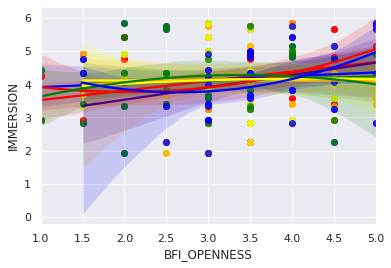

In [19]:
################################################################################ 1.Statistical Analysises between Immersion and 5 BFI: Mean case
                                                                                # Using linear regression, ordinary least square
bfi_list = []
for i in range(5):
    bfi_list.append(e_group.columns[i+4])

def immersion_bfi_sa(bfi_list):                                                 # Function for the Statistical Analysis
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):                                                 # Function for the Plot the IMMERSION and BFI in linear regression
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):                                                # Function for the Plot the IMMERSION and BFI in nonlinear regression
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group,
                    color = color[i], order = 2)

immersion_bfi_sa(bfi_list)                                                      # Statistical Analysis
immersion_bfi_pl(bfi_list)                                                      # Plot the IMMERSION and BFI in linear regression
immersion_bfi_pl2(bfi_list)                                                     # Plot the IMMERSION and BFI in nonlinear regression

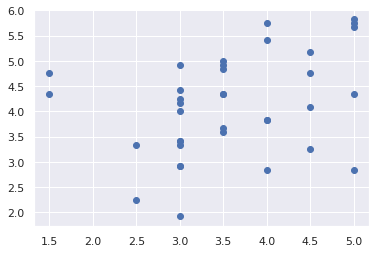

In [20]:
################################################################################2. BFI_OPENNESS and IMMERSION distribution
x = e_group['BFI_OPENNESS']                                                     # BFI_OPENNESS and IMMERSION
y = e_group['IMMERSION']
plt.scatter(x,y)

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.385
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0438
Time:                        01:06:43   Log-Likelihood:                -48.529
No. Observations:                  36   AIC:                             101.1
Df Residuals:                      34   BIC:                             104.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7916      0.654  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


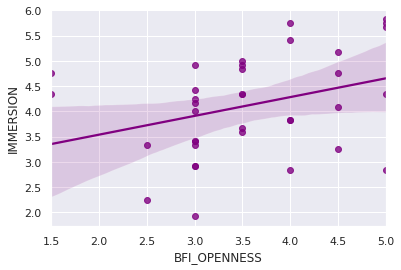

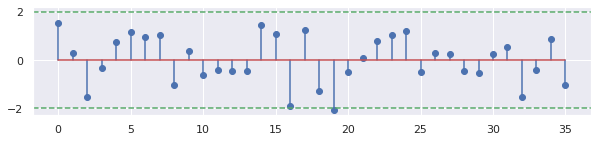

In [21]:
################################################################################ IMMERSION and BFI OPENNESS
res = smf.ols(formula='IMMERSION ~ BFI_OPENNESS', data = e_group).fit()         # Using linear regression, oridnary least square
sns.regplot(x="BFI_OPENNESS", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

BFI_OPENESS


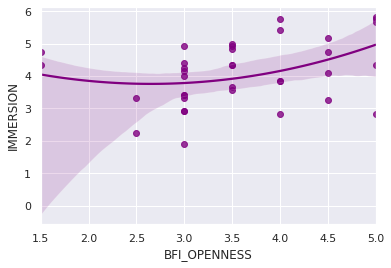

In [22]:
################################################################################ IMMERSION AND BFI OPENNESS
                                                                                # Plot the non-linear
sns.regplot(x="BFI_OPENNESS", y="IMMERSION",
            data = e_group, order = 2, color = 'purple')
print('BFI_OPENESS')

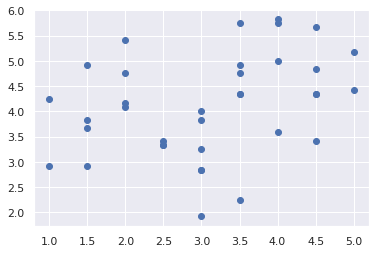

In [23]:
################################################################################ 3.BFI_EXTRAVERSION and IMMERSION
x = e_group['BFI_EXTRAVERSION']                                                 # BFI_EXTRAVERSION and IMMERSION distribution
y = e_group['IMMERSION']
plt.scatter(x,y)

BFI_EXTRAVERSION
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.081
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0513
Time:                        01:06:48   Log-Likelihood:                -48.673
No. Observations:                  36   AIC:                             101.3
Df Residuals:                      34   BIC:                             104.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


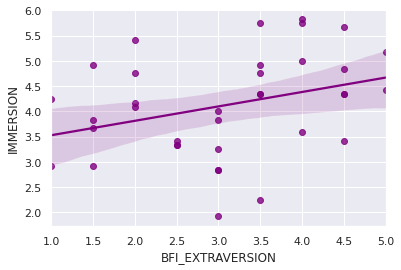

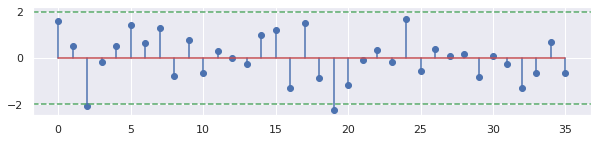

In [24]:
################################################################################ IMMERSION AND BFI_EXTRAVERSION
                                                                                # Using linear regression, oridnary least square
res = smf.ols(formula='IMMERSION ~ BFI_EXTRAVERSION', data = e_group).fit()
sns.regplot(x="BFI_EXTRAVERSION", y="IMMERSION", data=e_group, color='purple')
print('BFI_EXTRAVERSION')
print(res.summary())

plt.figure(figsize=(10, 2))                                                     # Check the outlier lower -2, over 2 considered as outlier
plt.stem(res.resid_pearson)
plt.axhline(2, c="g", ls="--")
plt.axhline(-2, c="g", ls="--")
plt.title("")
plt.show()

BFI_EXTRAVERSION


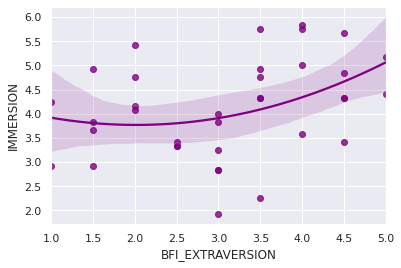

In [25]:
################################################################################ IMMERSION AND BFI_EXTRAVERSION
                                                                                # Plot the non-linear
sns.regplot(x="BFI_EXTRAVERSION", y="IMMERSION",
            data = a_group, order = 2, color = 'purple')
print('BFI_EXTRAVERSION')

In [26]:
################################################################################ PART IV: Model based data analysis
                                                                                # 1. Preprocess the dataset
gh_case = list(a_group.loc[a_group['TEXT']=='HARRY'].loc[:,['CASE']]['CASE'])   # HARRY CASE LIST "print(len(gh_case))"
gp_case = list(a_group.loc[a_group['TEXT']=='PIPPI'].loc[:,['CASE']]['CASE'])   # PIPPI CASE LIST "print(len(gp_case))"

tr_hr_case = gh_case[2:22]                                                      #training set for Text: HARRY, Condition: COHERENT
te_hr_case = gh_case[0:2] + gh_case[22:25]                                      #testing set for Text: HARRY, Condition: COHERENT
hr_case = [tr_hr_case, te_hr_case]                                              # training and testing cases for Text: HARRY, Condition: COHERENT

tr_pi_case = gp_case[0:10]                                                      #training set for Text: PIPPI, Condition: COHERENT, Language = ENG
te_pi_case = gp_case[10:14]                                                     #testing set for Text: PIPPI, Condition: COHERENT, Language = ENG
pi_case = [tr_pi_case, te_pi_case]                                              # PIPPI case

################################################################################ Load the independent variable related dataset
rh_set = rh.copy()
rp_set = rp.copy()

hr_train_arousal = []
hr_train_valence = []
hr_test_arousal = []
hr_test_valence = []

for i in hr_case:                                                               # Text: HARRY
    for j in i:                                                                 # Extract Arousal and Valence
        if i == tr_hr_case:
            set = rh_set[rh_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            hr_train_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            hr_train_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rh_set[rh_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            hr_test_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            hr_test_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

pi_train_arousal = []
pi_train_valence = []
pi_test_arousal = []
pi_test_valence = []

for i in pi_case:                                                               # Text: PIPPI
    for j in i:                                                                 # Extract Arousal and Valence
        if i == tr_pi_case:
            set = rp_set[rp_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            pi_train_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            pi_train_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rp_set[rp_set['CASE']==j]
            #new = set.sort_values(by='SENTENCE_NUMBER')
            pi_test_arousal.append(list(set.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            pi_test_valence.append(list(set.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

print('Coherent HARRY Dataset')                                                 # Set the input data for training set (as x_Train) and testing set (as x_Test)
print('train_arousal:',len(hr_train_arousal),hr_train_arousal)                  # The input data consists of the arounsal and valence ratings
print('train_valence:',len(hr_train_valence),hr_train_valence)
print('test_arousal:',len(hr_test_arousal),hr_test_arousal)
print('test_valence:',len(hr_test_valence),hr_test_valence)

print('Coherent PIPPI Dataset')
print('train_arousal:',len(pi_train_arousal),pi_train_arousal)
print('train_valence:',len(pi_train_valence),pi_train_valence)
print('test_arousal:',len(pi_test_arousal),pi_test_arousal)
print('test_valence:',len(pi_test_valence),pi_test_valence)

Coherent HARRY Dataset
train_arousal: 20 [[5.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0], [4.0, 4.0, 4.0, 2.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 1.0, 4.0, 3.0, 5.0, 5.0, 4.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 4.0, 2.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 

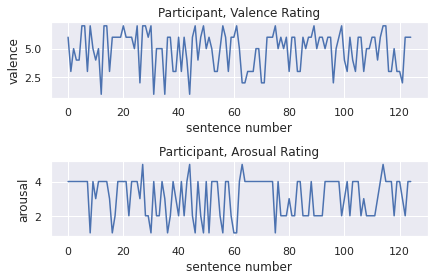

In [27]:
################################################################################ Plot the valence and arousal data
t = hr_train_valence[4]
s = hr_train_arousal[4]

plt.subplot(2, 1, 1)                                                            # VALENCE_RATING
plt.plot(t)
plt.xlabel('sentence number')
plt.ylabel('valence')
plt.title('Participant, Valence Rating')
plt.grid(True)

plt.subplot(2, 1, 2)                                                            # AROUSAL_RATING
plt.plot(s)
plt.title('Participant, Arosual Rating')
plt.xlabel('sentence number')
plt.ylabel('arousal')
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
################################################################################ Set the output data for the training set (as Y_Train) and test set (as Y_Test)
hr_train_immersion = []                                                         # The output data consists of the Immersion level as calculated above
hr_test_immersion = []

for i in hr_case:                                                               # HARRY IMMERSION DATASET
    for j in i:
        if i == tr_hr_case:
            hr_train_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))
        else:
            hr_test_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))

print('hr_train_immersion',len(hr_train_immersion),hr_train_immersion)
print('hr_test_immersion',len(hr_test_immersion),hr_test_immersion)

# PIPPI IMMERSION DATASET
pi_train_immersion = []
pi_test_immersion = []

for i in pi_case:                                                               # PIPPI IMMERSION DATASET
    for j in i:
        if i == tr_pi_case:
            pi_train_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))
        else:
            pi_test_immersion.append(list(a_group[a_group['CASE']==j]['IMMERSION']))

print('pi_train_immersion',len(pi_train_immersion),pi_train_immersion)
print('pi_test_immersion',len(pi_test_immersion),pi_test_immersion)

hr_train_immersion 20 [[2.25], [4.333333333333333], [5.166666666666667], [5.75], [5.0], [4.916666666666667], [2.9166666666666665], [4.25], [3.3333333333333335], [4.083333333333333], [3.6666666666666665], [3.8333333333333335], [4.75], [5.666666666666667], [2.8333333333333335], [5.833333333333333], [3.25], [1.9166666666666667], [3.4166666666666665], [4.0]]
hr_test_immersion 4 [[5.75], [4.75], [4.833333333333333], [4.333333333333333]]
pi_train_immersion 10 [[5.416666666666667], [3.4166666666666665], [4.166666666666667], [4.333333333333333], [3.8333333333333335], [3.5833333333333335], [4.333333333333333], [4.416666666666667], [2.8333333333333335], [3.3333333333333335]]
pi_test_immersion 2 [[4.916666666666667], [2.9166666666666665]]


In [29]:
################################################################################ Dataset as np.array
print('HARRY Dataset')                                                          # HARRY DATASET
hr_tr_arousal = np.array(hr_train_arousal)
hr_tr_valence = np.array(hr_train_valence)
hr_tr_immersion = np.array(hr_train_immersion)

hr_te_arousal = np.array(hr_test_arousal)
hr_te_valence = np.array(hr_test_valence)
hr_te_immersion = np.array(hr_test_immersion)

print('HARRY Training set')                                                     
print('hr_tr_arousal',hr_tr_arousal.shape,hr_tr_arousal)
print('hr_tr_valence',hr_tr_valence.shape,hr_tr_valence)
print('hr_tr_immersion',hr_tr_immersion.shape,hr_tr_immersion)

print('HARRY Test set')
print(hr_te_arousal)
print(hr_te_valence)
print(hr_te_immersion)

print('PIPPI Dataset')                                                          # PIPPI DATASET
pi_tr_arousal = np.array(pi_train_arousal)
pi_tr_valence = np.array(pi_train_valence)
pi_tr_immersion = np.array(pi_train_immersion)

pi_te_arousal = np.array(pi_test_arousal)
pi_te_valence = np.array(pi_test_valence)
pi_te_immersion = np.array(pi_test_immersion)

print('PIPPI Training set')
print('pi_tr_arousal',pi_tr_arousal.shape,pi_tr_arousal)
print('pi_tr_valence',pi_tr_valence.shape,pi_tr_valence)
print('pi_tr_immersion',pi_tr_immersion.shape,pi_tr_immersion)

print('PIPPI Test set')
print(pi_te_arousal)
print(pi_te_valence)
print(pi_te_immersion)

HARRY Dataset
HARRY Training set
hr_tr_arousal (20, 125) [[5. 4. 3. ... 2. 2. 2.]
 [4. 4. 4. ... 3. 4. 5.]
 [5. 4. 4. ... 4. 4. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 4. 5. ... 2. 2. 3.]
 [4. 4. 5. ... 3. 3. 2.]]
hr_tr_valence (20, 125) [[1. 2. 4. ... 5. 5. 6.]
 [5. 3. 5. ... 4. 4. 6.]
 [5. 5. 4. ... 5. 6. 7.]
 ...
 [4. 4. 3. ... 4. 4. 4.]
 [6. 6. 7. ... 6. 7. 6.]
 [6. 2. 7. ... 4. 4. 5.]]
hr_tr_immersion (20, 1) [[2.25      ]
 [4.33333333]
 [5.16666667]
 [5.75      ]
 [5.        ]
 [4.91666667]
 [2.91666667]
 [4.25      ]
 [3.33333333]
 [4.08333333]
 [3.66666667]
 [3.83333333]
 [4.75      ]
 [5.66666667]
 [2.83333333]
 [5.83333333]
 [3.25      ]
 [1.91666667]
 [3.41666667]
 [4.        ]]
HARRY Test set
[[4. 2. 1. 1. 1. 3. 4. 4. 2. 3. 3. 2. 4. 4. 3. 2. 2. 2. 2. 2. 4. 2. 1. 4.
  2. 2. 3. 2. 4. 3. 3. 2. 3. 2. 3. 2. 1. 4. 5. 4. 4. 2. 3. 3. 5. 1. 4. 3.
  4. 4. 2. 2. 1. 2. 2. 2. 2. 2. 4. 1. 3. 2. 4. 4. 4. 4. 5. 2. 2. 3. 4. 4.
  5. 2. 1. 3. 2. 1. 4. 4. 4. 2. 1. 4. 4. 2. 2. 1. 3. 1. 4. 3. 3. 

In [30]:
################################################################################ Version 1: Concatenate to design flatten (2,) dataset 
                                                                                #######HARRY dataset
print(hr_tr_arousal.shape)                                                      # In order to pass the input data in an optimal manner into the 
print(hr_tr_valence.shape)                                                      # machine learning algorithm, we will create an input dataset in the shape of 
print(hr_te_arousal.shape)                                                      # a three dimensional array (a, b, c) where
print(hr_te_valence.shape)                                                      #   a=2 - meaning two dependent variables (arousal and valence)
hr_tr_dataset = np.stack([hr_tr_arousal, hr_tr_valence], axis=0)                #   b= number of cases (20 for the training set, 4 for the test set)
hr_te_dataset = np.stack([hr_te_arousal, hr_te_valence], axis=0)                #   c=125 the number of individual ratings given (125 arousal and 125 valence ratings)

print(hr_tr_dataset.shape)
print(hr_te_dataset.shape)

print(pi_tr_arousal.shape)                                                      ####### PIPPI DATASET
print(pi_tr_valence.shape)                                                      # Same (a, b, c) structure as described above
print(pi_te_arousal.shape)
print(pi_te_valence.shape)
pi_tr_dataset = np.stack([pi_tr_arousal, pi_tr_valence], axis=0)
pi_te_dataset = np.stack([pi_te_arousal, pi_te_valence], axis=0)

print(pi_tr_dataset.shape)
print(pi_te_dataset.shape)

(20, 125)
(20, 125)
(4, 125)
(4, 125)
(2, 20, 125)
(2, 4, 125)
(10, 133)
(10, 133)
(2, 133)
(2, 133)
(2, 10, 133)
(2, 2, 133)


In [31]:
################################################################################ Version 2: Concatenate to design flatten (1,) dataset
hr_tr_dataset = np.concatenate((hr_tr_arousal, hr_tr_valence), axis = 1)        #######   HARRY dataset
hr_te_dataset = np.concatenate((hr_te_arousal, hr_te_valence), axis = 1)        # In order to pass the input data in an optimal manner into the 
print(hr_tr_dataset.shape,'tr_dataset')                                         # machine learning algorithm, we will create an input dataset in the shape of 
print(hr_tr_dataset)                                                            # a two dimensional array (a, b) where
print(hr_te_dataset.shape,'te_dataset')                                         #   a=number of cases (2- fot the training set, 4 for the test set)
print(hr_te_dataset)                                                            #   b=250, in which the first 125 values represent the arousal scores 
                                                                                #     and the next 125 values represent the the valence scores


pi_tr_dataset = np.concatenate((pi_tr_arousal, pi_tr_valence), axis = 1)        #######    PIPPI dataset
pi_te_dataset = np.concatenate((pi_te_arousal, pi_te_valence), axis = 1)        # Same (a, b) structure as described above

(20, 250) tr_dataset
[[5. 4. 3. ... 5. 5. 6.]
 [4. 4. 4. ... 4. 4. 6.]
 [5. 4. 4. ... 5. 6. 7.]
 ...
 [3. 3. 3. ... 4. 4. 4.]
 [3. 4. 5. ... 6. 7. 6.]
 [4. 4. 5. ... 4. 4. 5.]]
(4, 250) te_dataset
[[4. 2. 1. 1. 1. 3. 4. 4. 2. 3. 3. 2. 4. 4. 3. 2. 2. 2. 2. 2. 4. 2. 1. 4.
  2. 2. 3. 2. 4. 3. 3. 2. 3. 2. 3. 2. 1. 4. 5. 4. 4. 2. 3. 3. 5. 1. 4. 3.
  4. 4. 2. 2. 1. 2. 2. 2. 2. 2. 4. 1. 3. 2. 4. 4. 4. 4. 5. 2. 2. 3. 4. 4.
  5. 2. 1. 3. 2. 1. 4. 4. 4. 2. 1. 4. 4. 2. 2. 1. 3. 1. 4. 3. 3. 4. 3. 4.
  4. 4. 2. 4. 3. 4. 2. 3. 4. 4. 4. 1. 2. 2. 3. 1. 1. 4. 4. 4. 4. 4. 2. 4.
  4. 3. 2. 1. 4. 5. 6. 6. 7. 7. 7. 7. 7. 7. 6. 3. 4. 4. 5. 7. 6. 6. 6. 6.
  5. 6. 6. 7. 3. 5. 7. 4. 7. 5. 6. 6. 3. 5. 7. 4. 2. 4. 5. 5. 3. 4. 5. 4.
  4. 3. 6. 7. 4. 5. 7. 6. 5. 4. 5. 5. 5. 5. 6. 4. 6. 6. 6. 5. 6. 3. 3. 3.
  4. 5. 4. 2. 3. 5. 7. 7. 7. 6. 7. 5. 6. 6. 6. 7. 3. 3. 5. 6. 7. 4. 7. 4.
  5. 3. 4. 4. 3. 2. 3. 5. 5. 4. 3. 3. 4. 5. 5. 5. 6. 5. 5. 7. 7. 7. 5. 6.
  7. 6. 3. 6. 3. 3. 6. 6. 7. 4.]
 [4. 4. 4. 3. 3. 4. 4. 4. 3. 3

In [33]:
################################################################################ 2. Linear Regression for HARRY dataset (Text: Harry, Condition: COHERENT)
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 2ms/step - loss: 0.2820 - mae: 0.5142
expected_value 1.7837237119674683 	 real_value [2.25]
expected_value 3.7045867443084717 	 real_value [4.33333333]
expected_value 4.635229587554932 	 real_value [5.16666667]
expected_value 5.298860549926758 	 real_value [5.75]
expected_value 4.541839122772217 	 real_value [5.]
expected_value 4.5587592124938965 	 real_value [4.91666667]
expected_value 2.1309313774108887 	 real_value [2.91666667]
expected_value 3.9119653701782227 	 real_value [4.25]
expected_value 2.646000385284424 	 real_value [3.33333333]
expected_value 3.598337411880493 	 real_value [4.08333333]
expected_value 3.0534353256225586 	 real_value [3.66666667]
expected_value 3.252598762512207 	 real_value [3.83333333]
expected_value 4.088694095611572 	 real_value [4.75]
expected_value 5.078074932098389 	 real_value [5.66666667]
expected_value 2.2615280151367188 	 real_value [2.83333333]
expected_value 5.399324893951416 	 real_value [5

In [34]:
################################################################################ 3. Non-linear Regression for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 2ms/step - loss: 6.0162 - mae: 2.1889
expected_value 1.8694684505462646 	 real_value [2.25]
expected_value 1.8694684505462646 	 real_value [4.33333333]
expected_value 1.8694684505462646 	 real_value [5.16666667]
expected_value 1.8694684505462646 	 real_value [5.75]
expected_value 1.8694684505462646 	 real_value [5.]
expected_value 1.8694684505462646 	 real_value [4.91666667]
expected_value 1.8694684505462646 	 real_value [2.91666667]
expected_value 1.8694684505462646 	 real_value [4.25]
expected_value 1.8694684505462646 	 real_value [3.33333333]
expected_value 1.8694684505462646 	 real_value [4.08333333]
expected_value 1.8694684505462646 	 real_value [3.66666667]
expected_value 1.8694684505462646 	 real_value [3.83333333]
expected_value 1.8694684505462646 	 real_value [4.75]
expected_value 1.8694684505462646 	 real_value [5.66666667]
expected_value 1.8694684505462646 	 real_value [2.83333333]
expected_value 1.8694684505462646 	 real

In [54]:
################################################################################ 4. SVR, Support Vector Regressor for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(x_train,y_train)

print("train score")
y_pred = SupportVectorRegModel.predict(x_train)

for i, e in enumerate(y_pred):
    #print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])
    print(y_pred[i], y_train[i])

def MAE(y_train, y_pred):
  return np.mean(np.abs((y_train - y_pred)))
print('MAE:',MAE(y_train, y_pred))

print("test score")
y_pred = SupportVectorRegModel.predict(x_test)

for i, e in enumerate(y_pred):
    #print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])
    print(y_pred[i], y_test[i])

def MAE(y_test, y_pred):
  return np.mean(np.abs((y_test - y_pred)))
print('MAE:',MAE(y_test, y_pred))

train score
3.1212888255578157 [2.25]
4.233446884676581 [4.33333333]
4.7764979601661235 [5.16666667]
5.082013339662074 [5.75]
4.9001332260869646 [5.]
4.719286245148759 [4.91666667]
3.016460983412936 [2.91666667]
4.350133228633438 [4.25]
3.4333747317127816 [3.33333333]
4.183359415586052 [4.08333333]
3.675964526645105 [3.66666667]
3.892559095948986 [3.83333333]
4.650282630652823 [4.75]
4.8059603609827315 [5.66666667]
3.3141006726800426 [2.83333333]
4.931860807435915 [5.83333333]
3.34950086256386 [3.25]
2.8290046915806455 [1.91666667]
3.5776267358400813 [3.41666667]
4.099974723943466 [4.]
MAE: 1.07234884258125
test score
4.484433398062981 [5.75]
4.0180910956094635 [4.75]
4.198047777559859 [4.83333333]
4.335957590533428 [4.33333333]
MAE: 0.6767497414664515


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
################################################################################ 5. XGB Regressor for HARRY
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

xgb1 = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,n_jobs = 5,verbose=True)
xgb_grid.fit(x_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print("train score")
predict = xgb_grid.predict(x_train)
for i, e in enumerate(predict):
    print("expected_value",predict[i], '\t', "real_value", y_train[i])

def MAE(y_train, y_pred):
  return np.mean(np.abs((y_train - y_pred)))
print('MAE:',MAE(y_train, y_pred))

print("test score")
predict = xgb_grid.predict(x_test)
for i, e in enumerate(predict):
    print("expected_value",predict[i], '\t', "real_value", y_test[i])

def MAE(y_test, y_pred):
  return np.mean(np.abs((y_test - y_pred)))
print('MAE',MAE(y_test, y_pred))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    3.4s finished


0.45163034877075964
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
train score
expected_value 2.2483063 	 real_value [2.25]
expected_value 4.33134 	 real_value [4.33333333]
expected_value 5.165748 	 real_value [5.16666667]
expected_value 5.750025 	 real_value [5.75]
expected_value 4.999612 	 real_value [5.]
expected_value 4.916413 	 real_value [4.91666667]
expected_value 2.9130085 	 real_value [2.91666667]
expected_value 4.2494726 	 real_value [4.25]
expected_value 3.3318415 	 real_value [3.33333333]
expected_value 4.0830097 	 real_value [4.08333333]
expected_value 3.6643784 	 real_value [3.66666667]
expected_value 3.8326375 	 real_value [3.83333333]
expected_value 4.749811 	 real_value [4.75]
expected_value 5.665896 	 real_value [5.66666667]
expected_value 2.8333144 	 real_value [2.83333333]
expected_value 5.8133707 	 real_value [5.83333333]
expected_va

In [57]:
################################################################################ 6. NN, simple one for Text: HARRY, Condition: COHERENT
x_train = hr_tr_dataset.copy()                                                  # Characteristics: 5 layers
x_test = hr_te_dataset.copy()                                                   # Layer 1: Input layer, size = x_train.shape[1] which is 250
y_train = hr_tr_immersion.copy()                                                # Layer 2, 3, 4: size = 64
y_test = hr_te_immersion.copy()                                                 # Layer 5: Output layer, size = 1

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])
print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.2201
expected_value 2.1878015995025635 	 real_value [2.25]
expected_value 4.204949855804443 	 real_value [4.33333333]
expected_value 4.808202743530273 	 real_value [5.16666667]
expected_value 5.505250930786133 	 real_value [5.75]
expected_value 4.875970840454102 	 real_value [5.]
expected_value 4.6771087646484375 	 real_value [4.91666667]
expected_value 2.612358331680298 	 real_value [2.91666667]
expected_value 4.0843186378479 	 real_value [4.25]
expected_value 3.0491089820861816 	 real_value [3.33333333]
expected_value 3.91616153717041 	 real_value [4.08333333]
expected_value 3.292487144470215 	 real_value [3.66666667]
expected_value 3.4298782348632812 	 real_value [3.83333333]
expected_value 4.614651203155518 	 real_value [4.75]
expected_value 5.45326566696167 	 real_value [5.66666667]
expected_value 2.7969398498535156 	 real_value [2.83333333]
expected_value 5.6901936531066895 	 real_value [5.8333

In [58]:
################################################################################ 7. Linear Regression for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 2ms/step - loss: 16.2111 - mae: 3.9667
expected_value 0.0 	 real_value [5.41666667]
expected_value 0.0 	 real_value [3.41666667]
expected_value 0.0 	 real_value [4.16666667]
expected_value 0.0 	 real_value [4.33333333]
expected_value 0.0 	 real_value [3.83333333]
expected_value 0.0 	 real_value [3.58333333]
expected_value 0.0 	 real_value [4.33333333]
expected_value 0.0 	 real_value [4.41666667]
expected_value 0.0 	 real_value [2.83333333]
expected_value 0.0 	 real_value [3.33333333]
test score
1/1 [==============================] - 0s 2ms/step - loss: 16.3403 - mae: 3.9167
expected_value 0.0 	 real_value [4.91666667]
expected_value 0.0 	 real_value [2.91666667]


In [39]:
################################################################################ 8. Non-linear Regression for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(1, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 4ms/step - loss: 9.3606 - mae: 2.9806
expected_value 0.9860664010047913 	 real_value [5.41666667]
expected_value 0.9860664010047913 	 real_value [3.41666667]
expected_value 0.9860664010047913 	 real_value [4.16666667]
expected_value 0.9860664010047913 	 real_value [4.33333333]
expected_value 0.9860664010047913 	 real_value [3.83333333]
expected_value 0.9860664010047913 	 real_value [3.58333333]
expected_value 0.9860664010047913 	 real_value [4.33333333]
expected_value 0.9860664010047913 	 real_value [4.41666667]
expected_value 0.9860664010047913 	 real_value [2.83333333]
expected_value 0.9860664010047913 	 real_value [3.33333333]
test score
1/1 [==============================] - 0s 1ms/step - loss: 9.5884 - mae: 2.9306
expected_value 0.9860664010047913 	 real_value [4.91666667]
expected_value 0.9860664010047913 	 real_value [2.91666667]


In [59]:
################################################################################ 9. SVR, Support Vector Regressor for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(x_train,y_train)

print("train score")
y_pred = SupportVectorRegModel.predict(x_train)

for i, e in enumerate(y_pred):
    #print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])
    print(y_pred[i], y_train[i])

def MAE(y_train, y_pred):
  return np.mean(np.abs((y_train - y_pred)))
print('MAE:',MAE(y_train, y_pred))

print("test score")
y_pred = SupportVectorRegModel.predict(x_test)

for i, e in enumerate(y_pred):
    #print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])
    print(y_pred[i], y_test[i])

def MAE(y_test, y_pred):
  return np.mean(np.abs((y_test - y_pred)))
print('MAE:',MAE(y_test, y_pred))

train score
4.536345776358682 [5.41666667]
3.6242452144498474 [3.41666667]
4.067086642900938 [4.16666667]
4.2331196595475875 [4.33333333]
3.909859958814515 [3.83333333]
3.683891712496797 [3.58333333]
4.233105591430737 [4.33333333]
4.316452992183135 [4.41666667]
3.4948290140036584 [2.83333333]
3.433010123983675 [3.33333333]
MAE: 0.6169515895801642
test score
3.934013681819493 [4.91666667]
4.0526169614932535 [2.91666667]
MAE: 1.0000000000000002


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [62]:
################################################################################ 10. XGB Regressor for PIPPI
x_train = pi_tr_dataset.copy()
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,n_jobs = 5,verbose=True)
xgb_grid.fit(x_train,y_train)

print("train score")
predict = xgb_grid.predict(x_train)
for i, e in enumerate(predict):
    print("expected_value",predict[i], '\t', "real_value", y_train[i])

def MAE(y_train, y_pred):
  return np.mean(np.abs((y_train - y_pred)))
print('MAE:',MAE(y_train, y_pred))

print("test score")
predict = xgb_grid.predict(x_test)
for i, e in enumerate(predict):
    print("expected_value",predict[i], '\t', "real_value", y_test[i])

def MAE(y_test, y_pred):
  return np.mean(np.abs((y_test - y_pred)))
print('MAE',MAE(y_test, y_pred))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    2.9s finished


train score
expected_value 4.7931685 	 real_value [5.41666667]
expected_value 3.4594967 	 real_value [3.41666667]
expected_value 4.2163754 	 real_value [4.16666667]
expected_value 4.37864 	 real_value [4.33333333]
expected_value 3.8816383 	 real_value [3.83333333]
expected_value 3.6341617 	 real_value [3.58333333]
expected_value 4.3805523 	 real_value [4.33333333]
expected_value 4.466902 	 real_value [4.41666667]
expected_value 3.1725664 	 real_value [2.83333333]
expected_value 3.3822274 	 real_value [3.33333333]
MAE: 0.5666666666666667
test score
expected_value 3.8198614 	 real_value [4.91666667]
expected_value 3.9673865 	 real_value [2.91666667]
MAE 1.0000000000000002


In [63]:
################################################################################ 11. NN, simple one for PIPPI
x_train = pi_tr_dataset.copy()                                                  # Characteristics of the neural network: see above (For Text: HARRY)
x_test = pi_te_dataset.copy()
y_train = pi_tr_immersion.copy()
y_test = pi_te_immersion.copy()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,epochs = 100,batch_size=1, verbose=0)

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 4ms/step - loss: 0.3254 - mae: 0.5478
expected_value 4.630014419555664 	 real_value [5.41666667]
expected_value 3.0231151580810547 	 real_value [3.41666667]
expected_value 3.5936996936798096 	 real_value [4.16666667]
expected_value 3.6676814556121826 	 real_value [4.33333333]
expected_value 3.2694027423858643 	 real_value [3.83333333]
expected_value 2.9946179389953613 	 real_value [3.58333333]
expected_value 3.674158811569214 	 real_value [4.33333333]
expected_value 3.871814012527466 	 real_value [4.41666667]
expected_value 2.663433074951172 	 real_value [2.83333333]
expected_value 2.8003993034362793 	 real_value [3.33333333]
test score
1/1 [==============================] - 0s 1ms/step - loss: 1.8618 - mae: 1.3352
expected_value 3.3004825115203857 	 real_value [4.91666667]
expected_value 3.97092604637146 	 real_value [2.91666667]


In [67]:
################################################################################ 12. Neural network, Regression: Hyperparameter Optimization
x_train = hr_tr_dataset.copy()
x_test = hr_te_dataset.copy()
y_train = hr_tr_immersion.copy()
y_test = hr_te_immersion.copy()

def gridsearch_model(neurons1, neurons2, neurons3):                             ######### Grid Search function
                                                                                ############  Input:
    model = models.Sequential()
    model.add(layers.Dense(neurons1, activation='relu',                         #   neurons1 : integer, first dropout layer parameter      
                       input_shape=(x_train.shape[1],)))
    model.add(Dense(neurons2,activation = 'relu'))                              #   neurons2 : integer, first dropout layer parameter
    model.add(Dense(neurons3,activation = 'relu'))                              #   neurons3 : integer, second dropout layer parameter
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])             ###### Output:
    return model                                                                #    This function returns a model

model = KerasRegressor(build_fn=gridsearch_model, nb_epoch=100,                 # Grid Search, Hyper-parameter tuning for Text: HARRY, Condition: COHERENT
                       batch_size=4, verbose=0)

neurons1 = [32,64,128]                                                               
neurons2 = [32,64,128]
neurons3 = [32,64,128]

param_grid = dict(neurons1 = neurons1,neurons2 = neurons2,neurons3=neurons3)    # Grid Search parameter on hyper parameters
grid = GridSearchCV(estimator = model, param_grid = param_grid,n_jobs=-1)       # GridSearchCV process constructs and evaluates a model 
grid_result = grid.fit(x_train,y_train)                                         # for each combination of parameters.

means = grid_result.cv_results_['mean_test_score']                              # Summarize results
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean,stdev,param in zip(means,stds,params):
    print("%f (%f) with: %r" % (mean,stdev,param))
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

-1.557215 (1.021522) with: {'neurons1': 32, 'neurons2': 32, 'neurons3': 32}
-2.928118 (1.497198) with: {'neurons1': 32, 'neurons2': 32, 'neurons3': 64}
-2.854766 (2.221757) with: {'neurons1': 32, 'neurons2': 32, 'neurons3': 128}
-0.960995 (0.863337) with: {'neurons1': 32, 'neurons2': 64, 'neurons3': 32}
-1.694401 (0.514211) with: {'neurons1': 32, 'neurons2': 64, 'neurons3': 64}
-0.928261 (0.287157) with: {'neurons1': 32, 'neurons2': 64, 'neurons3': 128}
-1.228920 (0.932704) with: {'neurons1': 32, 'neurons2': 128, 'neurons3': 32}
-1.168036 (1.024299) with: {'neurons1': 32, 'neurons2': 128, 'neurons3': 64}
-2.527906 (1.813119) with: {'neurons1': 32, 'neurons2': 128, 'neurons3': 128}
-2.423369 (2.810467) with: {'neurons1': 64, 'neurons2': 32, 'neurons3': 32}
-1.691322 (0.914722) with: {'neurons1': 64, 'neurons2': 32, 'neurons3': 64}
-2.016048 (1.316568) with: {'neurons1': 64, 'neurons2': 32, 'neurons3': 128}
-3.040373 (2.864486) with: {'neurons1': 64, 'neurons2': 64, 'neurons3': 32}
-2.43

[32, 64, 128]
processing fold #: 1
processing fold #: 2
processing fold #: 3
processing fold #: 4
processing fold #: 5


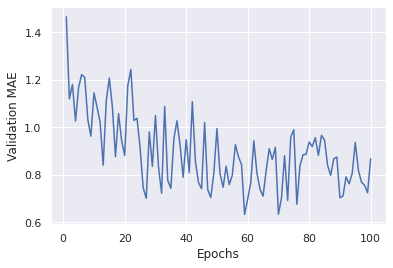

train score
1/1 [==============================] - 0s 1ms/step - loss: 31.5157 - mae: 5.4988
expected_value -1.7224961519241333 	 real_value [2.25]
expected_value -1.7292945384979248 	 real_value [4.33333333]
expected_value -1.0152642726898193 	 real_value [5.16666667]
expected_value -1.5939383506774902 	 real_value [5.75]
expected_value -1.3791207075119019 	 real_value [5.]
expected_value -2.0819358825683594 	 real_value [4.91666667]
expected_value -1.5237947702407837 	 real_value [2.91666667]
expected_value -1.8978662490844727 	 real_value [4.25]
expected_value -1.4095289707183838 	 real_value [3.33333333]
expected_value -1.2324750423431396 	 real_value [4.08333333]
expected_value -1.4848166704177856 	 real_value [3.66666667]
expected_value -1.5996131896972656 	 real_value [3.83333333]
expected_value -1.2080488204956055 	 real_value [4.75]
expected_value -1.9105298519134521 	 real_value [5.66666667]
expected_value -1.1708173751831055 	 real_value [2.83333333]
expected_value -0.518972

In [68]:
################################################################################ 12. Nueral network, Regression: Evaluation
para = grid_result.best_params_                                                 # Cross Validation for Text: HARRY, Condition: COHERENT
append = []
list = ['neurons1','neurons2','neurons3']
for i in list:
    append.append(para[i])
print(append)

k = 5                                                                           # K-fold cross-validation
num_val_samples = len(x_train) // k
num_epochs = 100
all_mae_scores = []

def build_model():                                                              ####### Define the model
    model = models.Sequential()                                                 # No Input
    model.add(layers.Dense(append[0], activation='relu',                        # Output: this function returns a model
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(append[1], activation='relu'))
    model.add(layers.Dense(append[2], activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

for i in range(k):
    print('processing fold #:', i+1)
    val_data = x_train[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
                                                                                # Build training and test sets
    partial_x_train = np.concatenate(                                           
        [x_train[:i * num_val_samples],
         x_train[(i+1) * num_val_samples:]],
         axis = 0)                                                              # partial_x_train: contains k-1 subgroups of the total train input dataset
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
         axis=0)                                                                # partial_train_targets: contains k-1 subgroups of the total train output data

    model = build_model()
    history = model.fit(partial_x_train, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=4, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_scores.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)             # Validation MAE Visualization
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

model = build_model()                                                           # Final model

print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

In [69]:
################################################################################ 12. Neural network, Regression
para = grid_result.best_params_                                                  # Final train and test of Text: HARRY, Condition: COHERENT
append = []
list = ['neurons1','neurons2','neurons3']
for i in list:
    print(para[i])
    append.append(para[i])
print(append)

model = models.Sequential()
model.add(layers.Dense(append[0], activation='relu',
                       input_shape=(x_train.shape[1],)))
model.add(layers.Dense(append[1], activation='relu'))
model.add(layers.Dense(append[2], activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train,y_train,epochs=70,batch_size=20,verbose=0)

test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

32
64
128
[32, 64, 128]
1/1 [==============================] - 0s 2ms/step - loss: 0.2310 - mae: 0.4515
expected_value 5.253340721130371 	 real_value [5.75]
expected_value 4.579037666320801 	 real_value [4.75]
expected_value 4.265566825866699 	 real_value [4.83333333]
expected_value 4.904130458831787 	 real_value [4.33333333]


In [71]:
print("train score")
test_mse_score, test_mae_score = model.evaluate(x_train, y_train)
result1 = model.predict(x_train, verbose=0)
for i, e in enumerate(result1):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_train[i])

print("test score")
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

result = model.predict(x_test, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", y_test[i])

train score
1/1 [==============================] - 0s 2ms/step - loss: 0.5771 - mae: 0.6099
expected_value 4.044911861419678 	 real_value [2.25]
expected_value 4.954305648803711 	 real_value [4.33333333]
expected_value 5.272212028503418 	 real_value [5.16666667]
expected_value 5.271928310394287 	 real_value [5.75]
expected_value 5.381533622741699 	 real_value [5.]
expected_value 4.892996311187744 	 real_value [4.91666667]
expected_value 3.2382984161376953 	 real_value [2.91666667]
expected_value 4.721093654632568 	 real_value [4.25]
expected_value 3.8956215381622314 	 real_value [3.33333333]
expected_value 4.428449630737305 	 real_value [4.08333333]
expected_value 4.348679542541504 	 real_value [3.66666667]
expected_value 4.174821376800537 	 real_value [3.83333333]
expected_value 5.456435203552246 	 real_value [4.75]
expected_value 5.721632480621338 	 real_value [5.66666667]
expected_value 3.982419967651367 	 real_value [2.83333333]
expected_value 5.65528678894043 	 real_value [5.83333